<a href="https://colab.research.google.com/github/MAL3X-01/DS-Unit-2-Tree-Ensembles/blob/master/module1-decision-trees/DS5_decision_trees_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science_

This sprint, your project is about water pumps in Tanzania. Can you predict which water pumps are faulty?

# Decision Trees

#### Objectives
- clean data with outliers
- impute missing values
- use scikit-learn for decision trees
- understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions
- get and interpret feature importances of a tree-based model

#### Links

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)

### Libraries


#### category_encoders

You aren't required to use [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding), but it's recommended.

If you're working locally, you already installed it, probably with this shell command: `conda install -c conda-forge category_encoders` 

If you're using Google Colab, you need to reinstall it every time you restart all runtimes: `pip install category_encoders`


#### scikit-learn version 0.21.2

Until recently, scikit-learn required graphviz to visualize decision trees, and it could be a pain to install. But sklearn's newest versions have a [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function that uses matplotlib!

Google Colab already has version 0.21.2. But if you're running Anaconda locally, you may need to upgrade.

You can check your version with this Python code: `import sklearn; print(sklearn.__version__)`

If necessary, you can update your version with this shell command: `conda update scikit-learn`

This isn't required to do your assignment, but it's required to run this lecture notebook.

#### pdpbox

[PDPbox](https://github.com/SauceCat/PDPbox) stands for "Partial Dependence Plot toolbox." It's a tool for model interpretation & visualization.

You can install it on Colab or locally with this shell command: `pip install pdpbox`

This also isn't required to do your assignment, but it's used in the lecture notebook.

In [1]:
!pip install pdpbox category_encoders

## Clean data with outliers, impute missing values (example solutions)

In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/'

train = pd.merge(pd.read_csv(WEB + 'train_features.csv'), 
                 pd.read_csv(WEB + 'train_labels.csv'))
test = pd.read_csv(WEB + 'test_features.csv')
sample_submission = pd.read_csv(WEB + 'sample_submission.csv')

# Split train into train & val
#train, val = train_test_split(train, train_size=0.70, test_size=0.30, 
                              #stratify=train['status_group'], random_state=42)

#train.shape, val.shape, test.shape

Some of the locations are at ["Null Island"](https://en.wikipedia.org/wiki/Null_Island) instead of Tanzania.

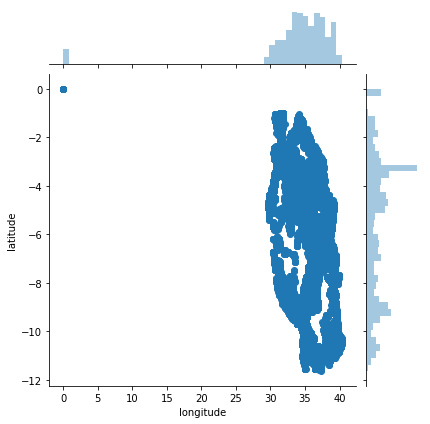

In [4]:
sns.jointplot(x='longitude', y='latitude', data=train);

In [0]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000
mean,37037.915699,321.925261,669.567656,34.082431,-5.705946e+00,0.477736,15.258291,5.616751,179.805513,1302.768939
std,21412.099719,3197.240487,693.005745,6.552053,2.941332e+00,13.312977,17.530228,9.621230,463.081564,950.955437
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18482.750000,0.000000,0.000000,33.092142,-8.528215e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,36986.500000,0.000000,372.500000,34.910740,-5.021436e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55450.250000,25.000000,1320.000000,37.170578,-3.327185e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-2.000000e-08,1776.000000,99.000000,80.000000,15300.000000,2013.000000


#### Define a function to wrangle train, validate, and test sets in the same way.

Fix the location, and do more data cleaning and feature engineering.

In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    X['construct_avail'] = X['construction_year'].apply(lambda x: 1 if x > 1500 else 0)
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        #X[col] = X[col].fillna(pd.concat([train, test])[col].mean())
        #X[col] = X[col].fillna(X[col].mean())
        
    water_per_person = X['amount_tsh']/ X['population']  
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['week_recorded'] = X['date_recorded'].dt.week
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
#val = wrangle(val)
test = wrangle(test)

In [0]:
cols_ = ['construction_year', 'longitude', 'latitude']
def wrangle2(X):
  for col in cols_:
    X[col] = X[col].fillna(pd.concat([train, test])[col].median())
  return X

In [5]:
train = wrangle2(train)
test = wrangle2(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [6]:
train['construction_year'].value_counts().head()

2000.0    22800
2010.0     2645
2008.0     2613
2009.0     2533
2007.0     1587
Name: construction_year, dtype: int64

In [7]:
train['year_recorded'].value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: year_recorded, dtype: int64

In [0]:
train['construction_year'] = train['construction_year'].apply(lambda x: int(x))
test['construction_year'] = test['construction_year'].apply(lambda x: int(x))

In [0]:
train['age'] = (train['year_recorded'] - train['construction_year']) 
test['age'] = (test['year_recorded'] - test['construction_year']) 
#val['age'] = (val['year_recorded'] - val['construction_year']) 

In [0]:
#X_train['age'] = X_train['age'].replace(0, round(pd.concat([X_train,X_test])['age'].mean()))

In [10]:
train['age'].value_counts()

 11    14695
 12     5701
 13     4079
 3      2740
 1      2303
 2      2130
 5      1980
 4      1903
 7      1404
 6      1381
 8      1160
 14     1160
 33     1120
 15      993
 23      905
 10      868
 16      826
 9       814
 19      766
 27      762
 18      754
 28      709
 31      709
 35      647
 17      636
 39      601
 37      600
 26      589
 0       588
 25      583
 21      578
 29      564
 20      541
 41      488
 30      359
 43      356
 38      351
 36      325
 22      323
 24      261
 40      233
 34      184
 32      174
 53       91
 42       90
 50       84
 45       66
 46       48
 44       47
 48       41
 51       31
 49       25
 47       14
 52       11
-5         3
-4         2
-7         1
-1         1
-3         1
-2         1
Name: age, dtype: int64

In [0]:
train['age'] = train['age'].apply(lambda x : np.NaN if x<=0 else x)
test['age'] = test['age'].apply(lambda x : np.NaN if x<=0 else x)
#val['age'] = val['age'].apply(lambda x : 0 if x<0 else x)

In [12]:
train['age'] = train['age'].fillna(round(pd.concat([train,test])['age'].mean()))
test['age'] = test['age'].fillna(round(pd.concat([train,test])['age'].mean()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [0]:
#train['age'] = train['age'].fillna(train['age'].mean())
#test['age'] = test['age'].fillna(test['age'].mean())
#val['age'] = val['age'].apply(lambda x : val['age'].mean() if x==0 else x)

In [19]:
train['gps_height'].value_counts().head()

 1015.0    20458
-15.0         60
-16.0         55
-13.0         55
 1290.0       52
Name: gps_height, dtype: int64

In [0]:
train['gps_height'] = train['gps_height'].apply(lambda x : np.NaN if x==0 else x)
test['gps_height'] = test['gps_height'].apply(lambda x : np.NaN if x==0 else x)

In [14]:
train['gps_height'] = train['gps_height'].fillna(round(pd.concat([train,test])['gps_height'].mean()))
test['gps_height'] = test['gps_height'].fillna(round(pd.concat([train,test])['gps_height'].mean()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [15]:
train, val = train_test_split(train, train_size=0.70, test_size=0.30, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((41580, 45), (17820, 45), (14358, 44))

Now the locations look better.

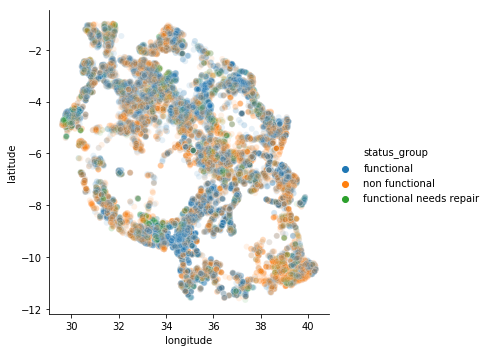

In [0]:
sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.1);

#### Select features

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id', 'num_private', 'wpt_name',
                                    'recorded_by', 'construction_year','subvillage',
                                    'amount_tsh'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()
#categorical_features = ['quantity', 'waterpoint_type', 'extraction_type', 'water_quality',
                        #'payment_type', 'management', 'region', 'source']

# Combine the lists 
features = numeric_features + categorical_features

In [25]:
test.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,age
0,2013-02-04,Dmdd,1996.0,DMDD,35.290799,-4.059696,Internal,Manyara,21,3,Mbulu,Bashay,321,True,Parastatal,MISSING,True,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2013,1.0
1,2013-02-04,Government Of Tanzania,1569.0,DWE,36.656709,-3.309214,Pangani,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,VWC,TPRI pipe line,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2013,13.0
2,2013-02-01,MISSING,1567.0,MISSING,34.767863,-5.004344,Internal,Singida,13,2,Singida Rural,Puma,500,True,VWC,P,MISSING,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2013,3.0
3,2013-01-22,Finn Water,267.0,FINN WATER,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,80,43,Liwale,Mkutano,250,MISSING,VWC,MISSING,True,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,2013,26.0
4,2013-03-27,Bruder,1260.0,BRUDER,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,10,3,Mbinga,Mbinga Urban,60,MISSING,Water Board,BRUDER,True,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,13.0


In [0]:
test = test.drop(columns=['id', 'num_private', 'wpt_name',
                                    'recorded_by', 'construction_year','subvillage',
                                    'amount_tsh'])

In [53]:
train.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
source                   0
source_type              0
source_class             0
w

#### Encode categoricals, scale features, fit and score Logistic Regression model, make predictions

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 5974 to 49783
Data columns (total 42 columns):
id                       41580 non-null int64
amount_tsh               41580 non-null float64
date_recorded            41580 non-null datetime64[ns]
funder                   41580 non-null int64
gps_height               41580 non-null int64
installer                41580 non-null int64
longitude                41580 non-null float64
latitude                 41580 non-null float64
wpt_name                 41580 non-null int64
num_private              41580 non-null int64
basin                    41580 non-null object
subvillage               41580 non-null int64
region                   41580 non-null object
region_code              41580 non-null int64
district_code            41580 non-null int64
lga                      41580 non-null object
ward                     41580 non-null object
population               41580 non-null int64
public_meeting           41580 non-null o

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on train, transform on val & test
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Model: Fit on train, score on val, predict on test
model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Write submission csv file
#submission = sample_submission.copy()
#ubmission['status_group'] = y_pred
#submission.to_csv('submission-02.csv', index=False)

Validation Accuracy 0.7379910213243547


In [22]:
# mean score 0.8055555555555556
from sklearn.ensemble import RandomForestClassifier
forest= RandomForestClassifier(n_jobs=-1, n_estimators= 450, random_state=40)
forest.fit(X_train_scaled, y_train)
forest.score(X_val_scaled, y_val)

0.8046576879910213

In [8]:
X_test_subset = test[features]
X_test_encoded = encoder.transform(X_test_subset)
X_test_scaled = scaler.transform(X_test_encoded)
all(X_test_encoded.columns == X_train_encoded.columns)

True

In [0]:
y_pred = forest.predict(X_test_scaled)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-11.csv', index=False)

In [10]:
!head submission-11.csv

id,status_group
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,functional
28965,non functional
36301,non functional


#### Get and plot coefficients

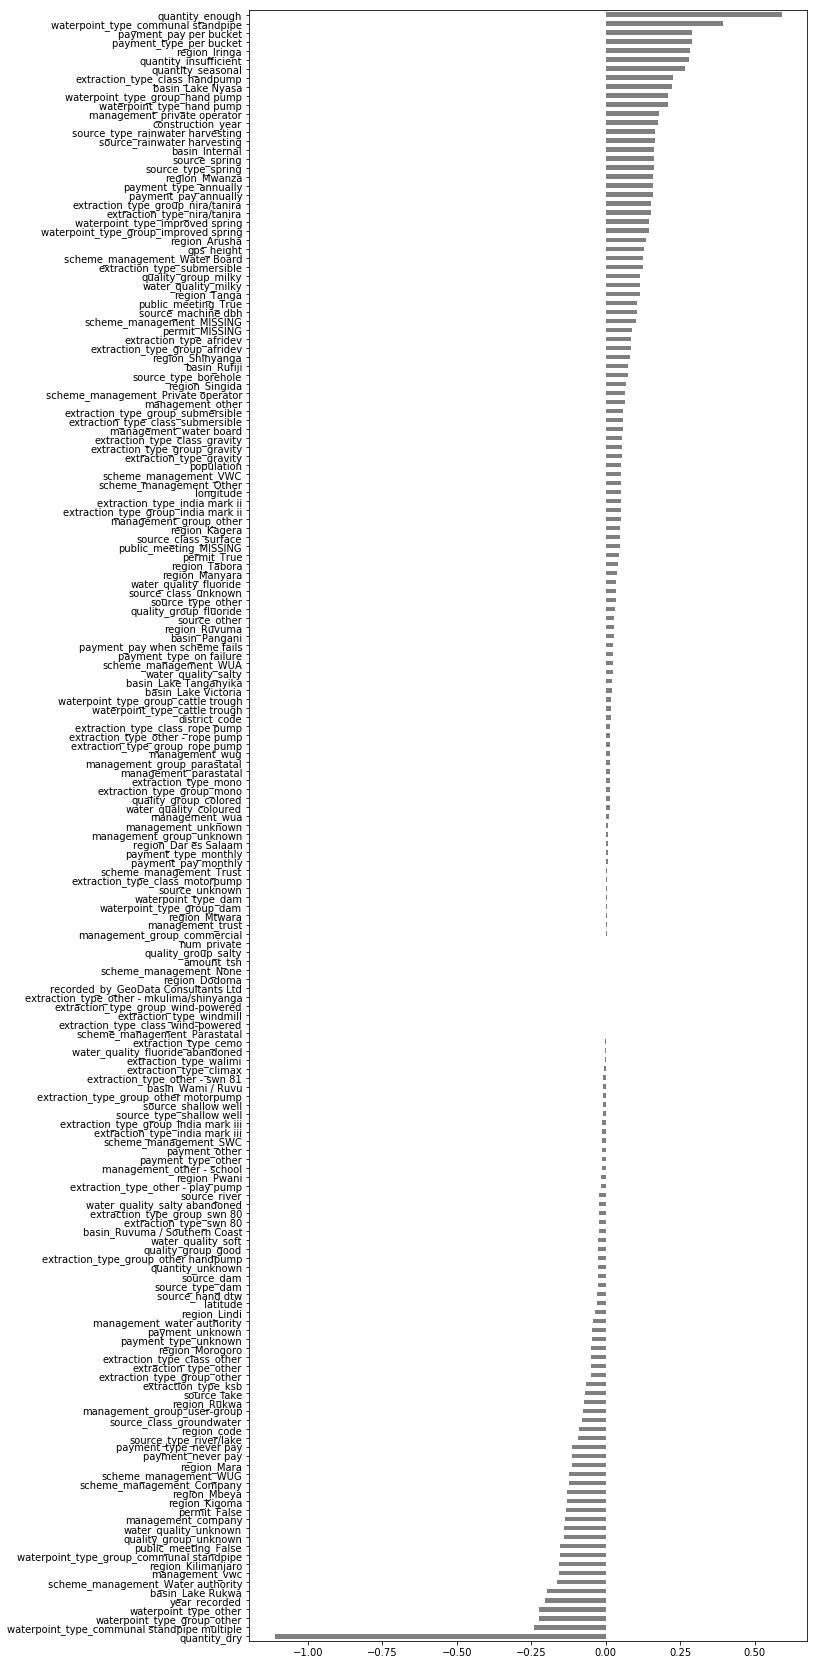

In [8]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

## Use scikit-learn for decision trees

### Compare a Logistic Regression with 2 features, longitude & latitude ...

In [0]:
train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

In [0]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
lr.fit(train_location, y_train)
print('Logistic Regression:')
print('Train Accuracy', lr.score(train_location, y_train))
print('Validation Accuracy', lr.score(val_location, y_val))

Logistic Regression:
Train Accuracy 0.5430765993265994
Validation Accuracy 0.5430976430976431


### ... versus a Decision Tree Classifier with 2 features, longitude & latitude

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [0]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_location, y_train)
print('Decision Tree:')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree:
Train Accuracy 0.984196127946128
Validation Accuracy 0.6301346801346801


In [0]:
dt = DecisionTreeClassifier(min_samples_leaf=25, random_state=42)
dt.fit(train_location, y_train)
print('Decision Tree:')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree:
Train Accuracy 0.7018939393939394
Validation Accuracy 0.6501683501683502


## Understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions

#### What does _(non)monotonic_ mean?!?!
- See Figures 1-3 in Wikipedia's article, [Monotonic function](https://en.wikipedia.org/wiki/Monotonic_function)
- See [World Population Growth, 1700-2010](https://ourworldindata.org/world-population-growth-past-future). World Population is non-linear and monotonic. Annual growth rate is non-linear and non-monotonic.
- See [Accidents per Mile Driven, by Driver Age](http://howwedrive.com/2009/02/20/whats-the-real-risk-of-older-drivers/). This is non-linear and non-monotonic.

#### What does _feature interactions_ mean?!?!
- See the explanation in [_Interpretable Machine Learning_, Chapter 5.4.1, Feature Interaction](https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction).
- See the exploration in this notebook, under the heading ***Interlude #2: Simple housing***

### Visualize decision tree

https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

### Make 3 heatmaps, with longitude & latitude
- Actual % of functional waterpumps
- Decision Tree predicted probability of functional waterpumps
- Logistic Regression predicted probability of functional waterpumps

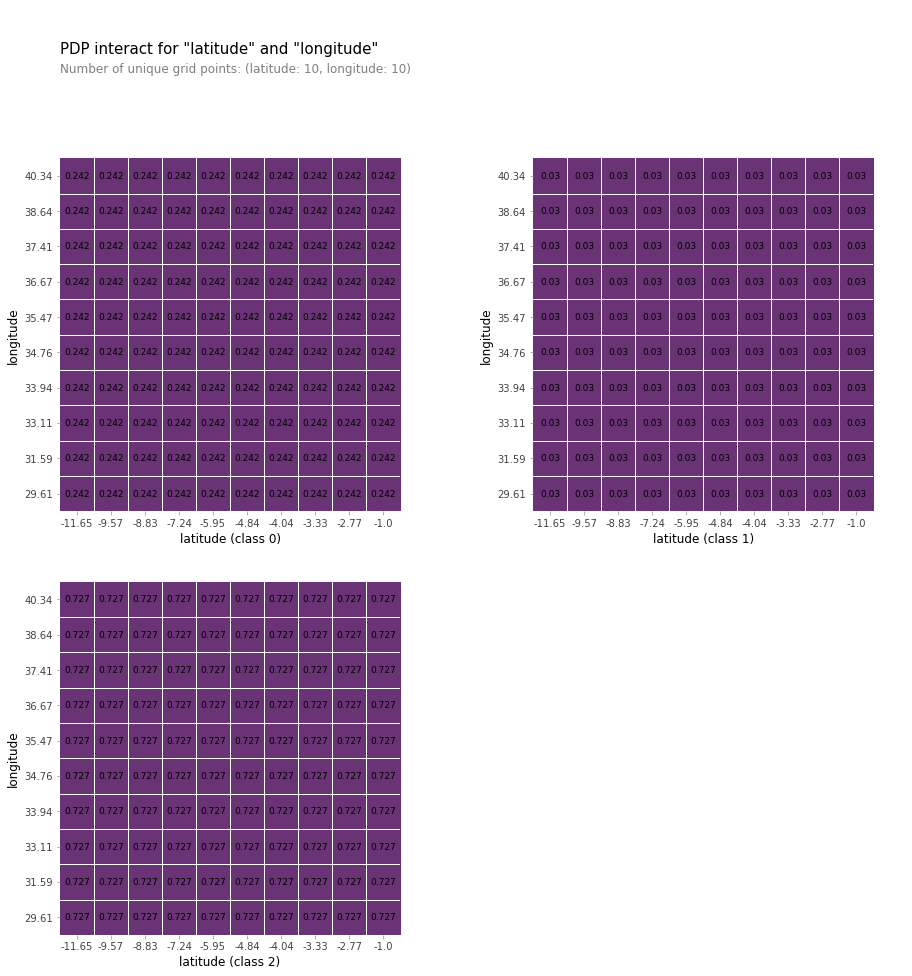

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['latitude', 'longitude']

interaction = pdp_interact(
    model=dt, 
    dataset=train_location, 
    model_features=features, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Interlude #1: predicting golf putts
(1 feature, non-linear, regression)

https://statmodeling.stat.columbia.edu/2008/12/04/the_golf_puttin/

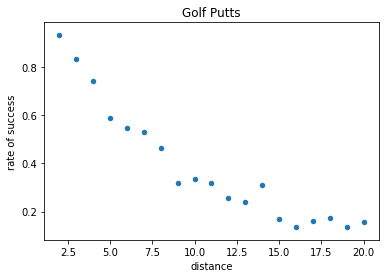

In [0]:
columns = ['distance', 'tries', 'successes']
data = [[2, 1443, 1346],
        [3, 694, 577],
        [4, 455, 337],
        [5, 353, 208],
        [6, 272, 149],
        [7, 256, 136],
        [8, 240, 111],
        [9, 217, 69],
        [10, 200, 67],
        [11, 237, 75],
        [12, 202, 52],
        [13, 192, 46],
        [14, 174, 54],
        [15, 167, 28],
        [16, 201, 27],
        [17, 195, 31],
        [18, 191, 33],
        [19, 147, 20],
        [20, 152, 24]]

putts = pd.DataFrame(columns=columns, data=data)
putts['rate of success'] = putts['successes'] / putts['tries']
putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts');

#### Compare Linear Regression ... 

R^2 Score 0.8695850610243295


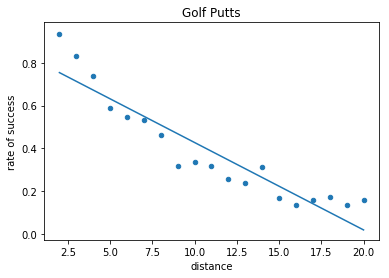

In [0]:
from sklearn.linear_model import LinearRegression

putts_X = putts[['distance']]
putts_y = putts['rate of success']
lr = LinearRegression()
lr.fit(putts_X, putts_y)
print('R^2 Score', lr.score(putts_X, putts_y))
ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
ax.plot(putts_X, lr.predict(putts_X));

#### ... versus a Decision Tree Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [0]:
!pip install graphviz

In [0]:
import graphviz
from ipywidgets import interact
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

def putts_tree(max_depth=1):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(putts_X, putts_y)
    print('R^2 Score', tree.score(putts_X, putts_y))
    ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
    ax.step(putts_X, tree.predict(putts_X), where='mid')
    plt.show()
    display(viztree(tree, feature_names=['distance']))

interact(putts_tree, max_depth=(1,6,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), Output()), _dom_classes=('wid…

### Interlude #2: Simple housing 
(2 features, regression)

https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction

In [0]:
columns = ['Price', 'Good Location', 'Big Size']

data = [[300000, 1, 1], 
        [200000, 1, 0], 
        [250000, 0, 1], 
        [150000, 0, 0]]

house = pd.DataFrame(columns=columns, data=data)
house

,Price,Good Location,Big Size
0,300000,1,1
1,200000,1,0
2,250000,0,1
3,150000,0,0


#### Compare Linear Regression ... 

In [0]:
house_X = house.drop(columns='Price')
house_y = house['Price']
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

R^2 1.0
Intercept 	 150000.0
Good Location     50000.0
Big Size         100000.0


#### ... versus a Decision Tree Regressor

R^2 1.0


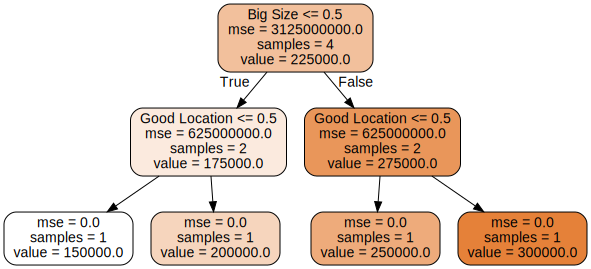

In [0]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)

### Simple housing, with a twist: _Feature Interaction_

In [0]:
house.loc[0, 'Price'] = 400000
house_X = house.drop(columns='Price')
house_y = house['Price']
house

,Price,Good Location,Big Size
0,400000,1,1
1,200000,1,0
2,250000,0,1
3,150000,0,0


#### Compare Linear Regression ... 

In [0]:
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

R^2 0.9285714285714286
Intercept 	 125000.0
Good Location    100000.0
Big Size         150000.0


#### ... versus a Decision Tree Regressor

R^2 1.0


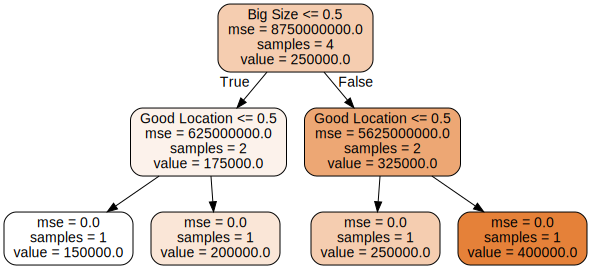

In [0]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)

## Get and interpret feature importances of a tree-based model

In [0]:
model = DecisionTreeClassifier(max_depth=15, random_state=42)
model.fit(X_train_encoded, y_train)
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

Train Accuracy 0.8318392255892256
Validation Accuracy 0.7683501683501683


In [0]:
len(X_train_encoded.columns)

181

In [0]:
len(model.feature_importances_)

181

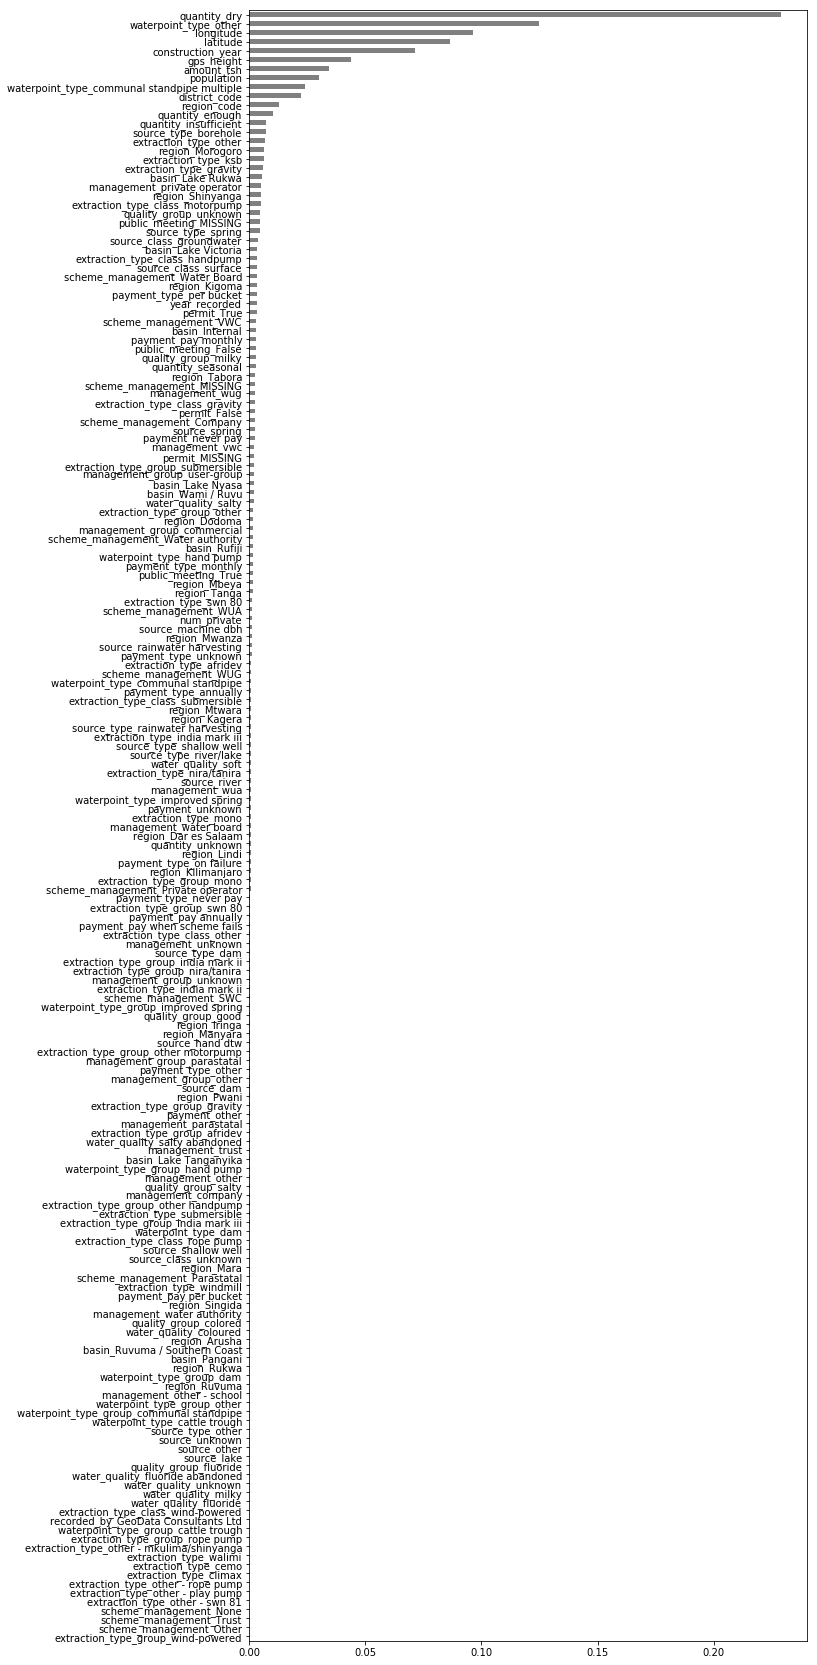

In [0]:
importances = pd.Series(model.feature_importances_, 
                        X_train_encoded.columns)

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

# Assignment
- Start a clean notebook, or continue with yesterday's assignment notebook.
- Continue to participate in our Kaggle competition with the Tanzania Waterpumps data. 
- Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- Try a Decision Tree Classifier. 
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- Create visualizations and share on Slack.
- Read more about decision trees and tree ensembles. You can start with the links at the top of this notebook.
- Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.
